<a href="https://colab.research.google.com/github/kimmunsu/24_langchain_study_colab/blob/main/Ch07_03_web_crawling_do_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install -q langchain-google-genai langchain playwright beautifulsoup4 tiktoken
! playwright install
%pip install -qU nest-asyncio
import nest_asyncio
nest_asyncio.apply() # Jupyter Notebook 의 이벤트 루프를 가져옵니다. (https://colab.research.google.com/drive/1YLjv3px-pVPlXtJv1hurzL9Fp3fZBJZI#scrollTo=BmjmSyYngnF1&line=7&uniqifier=1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00
Playwright Host validation warning: 
╔══════════════════════════════════════════════════════╗
║ Host system is missing dependencies to run browsers. ║
║ Missing libraries:                                   ║
║     libwoff2dec.so.1.0.2                             ║
║     libgstgl-1.0.so.0                                ║
║     libgstcodecparsers-1.0.so.0                      ║
║     libharfbuzz-icu.so.0                             ║
║     libenchant-2.so.2                                ║
║     libsecret-1.so.0                                 ║
║     libhyphen.so.0                                   ║
║     libmanette-0.2.so.0                              ║
╚══════════════════════════════════════════════════════╝
    at validateDependenciesLinux (/usr/local/lib/python3.10/dist-packages/playwright/driver/package/lib/server/registry/dependencies.js:216:9)
    at process.processTicksAndRejections (node:internal/p

**AsyncChromiumLoader를 사용해서 특정 웹사이트의 HTML 가져오기**

사실 전통적으로 파이썬으로 크롤링하면 requests.get을 통해 html 가져오고 beautifulsoup를 통해 html을 분석하는데, AsyncChromiumLoader는 langchain에서 제공하는 html을 비동기로 가져오는 컴포넌트이다.

사용법은 간단히 아래와 같다.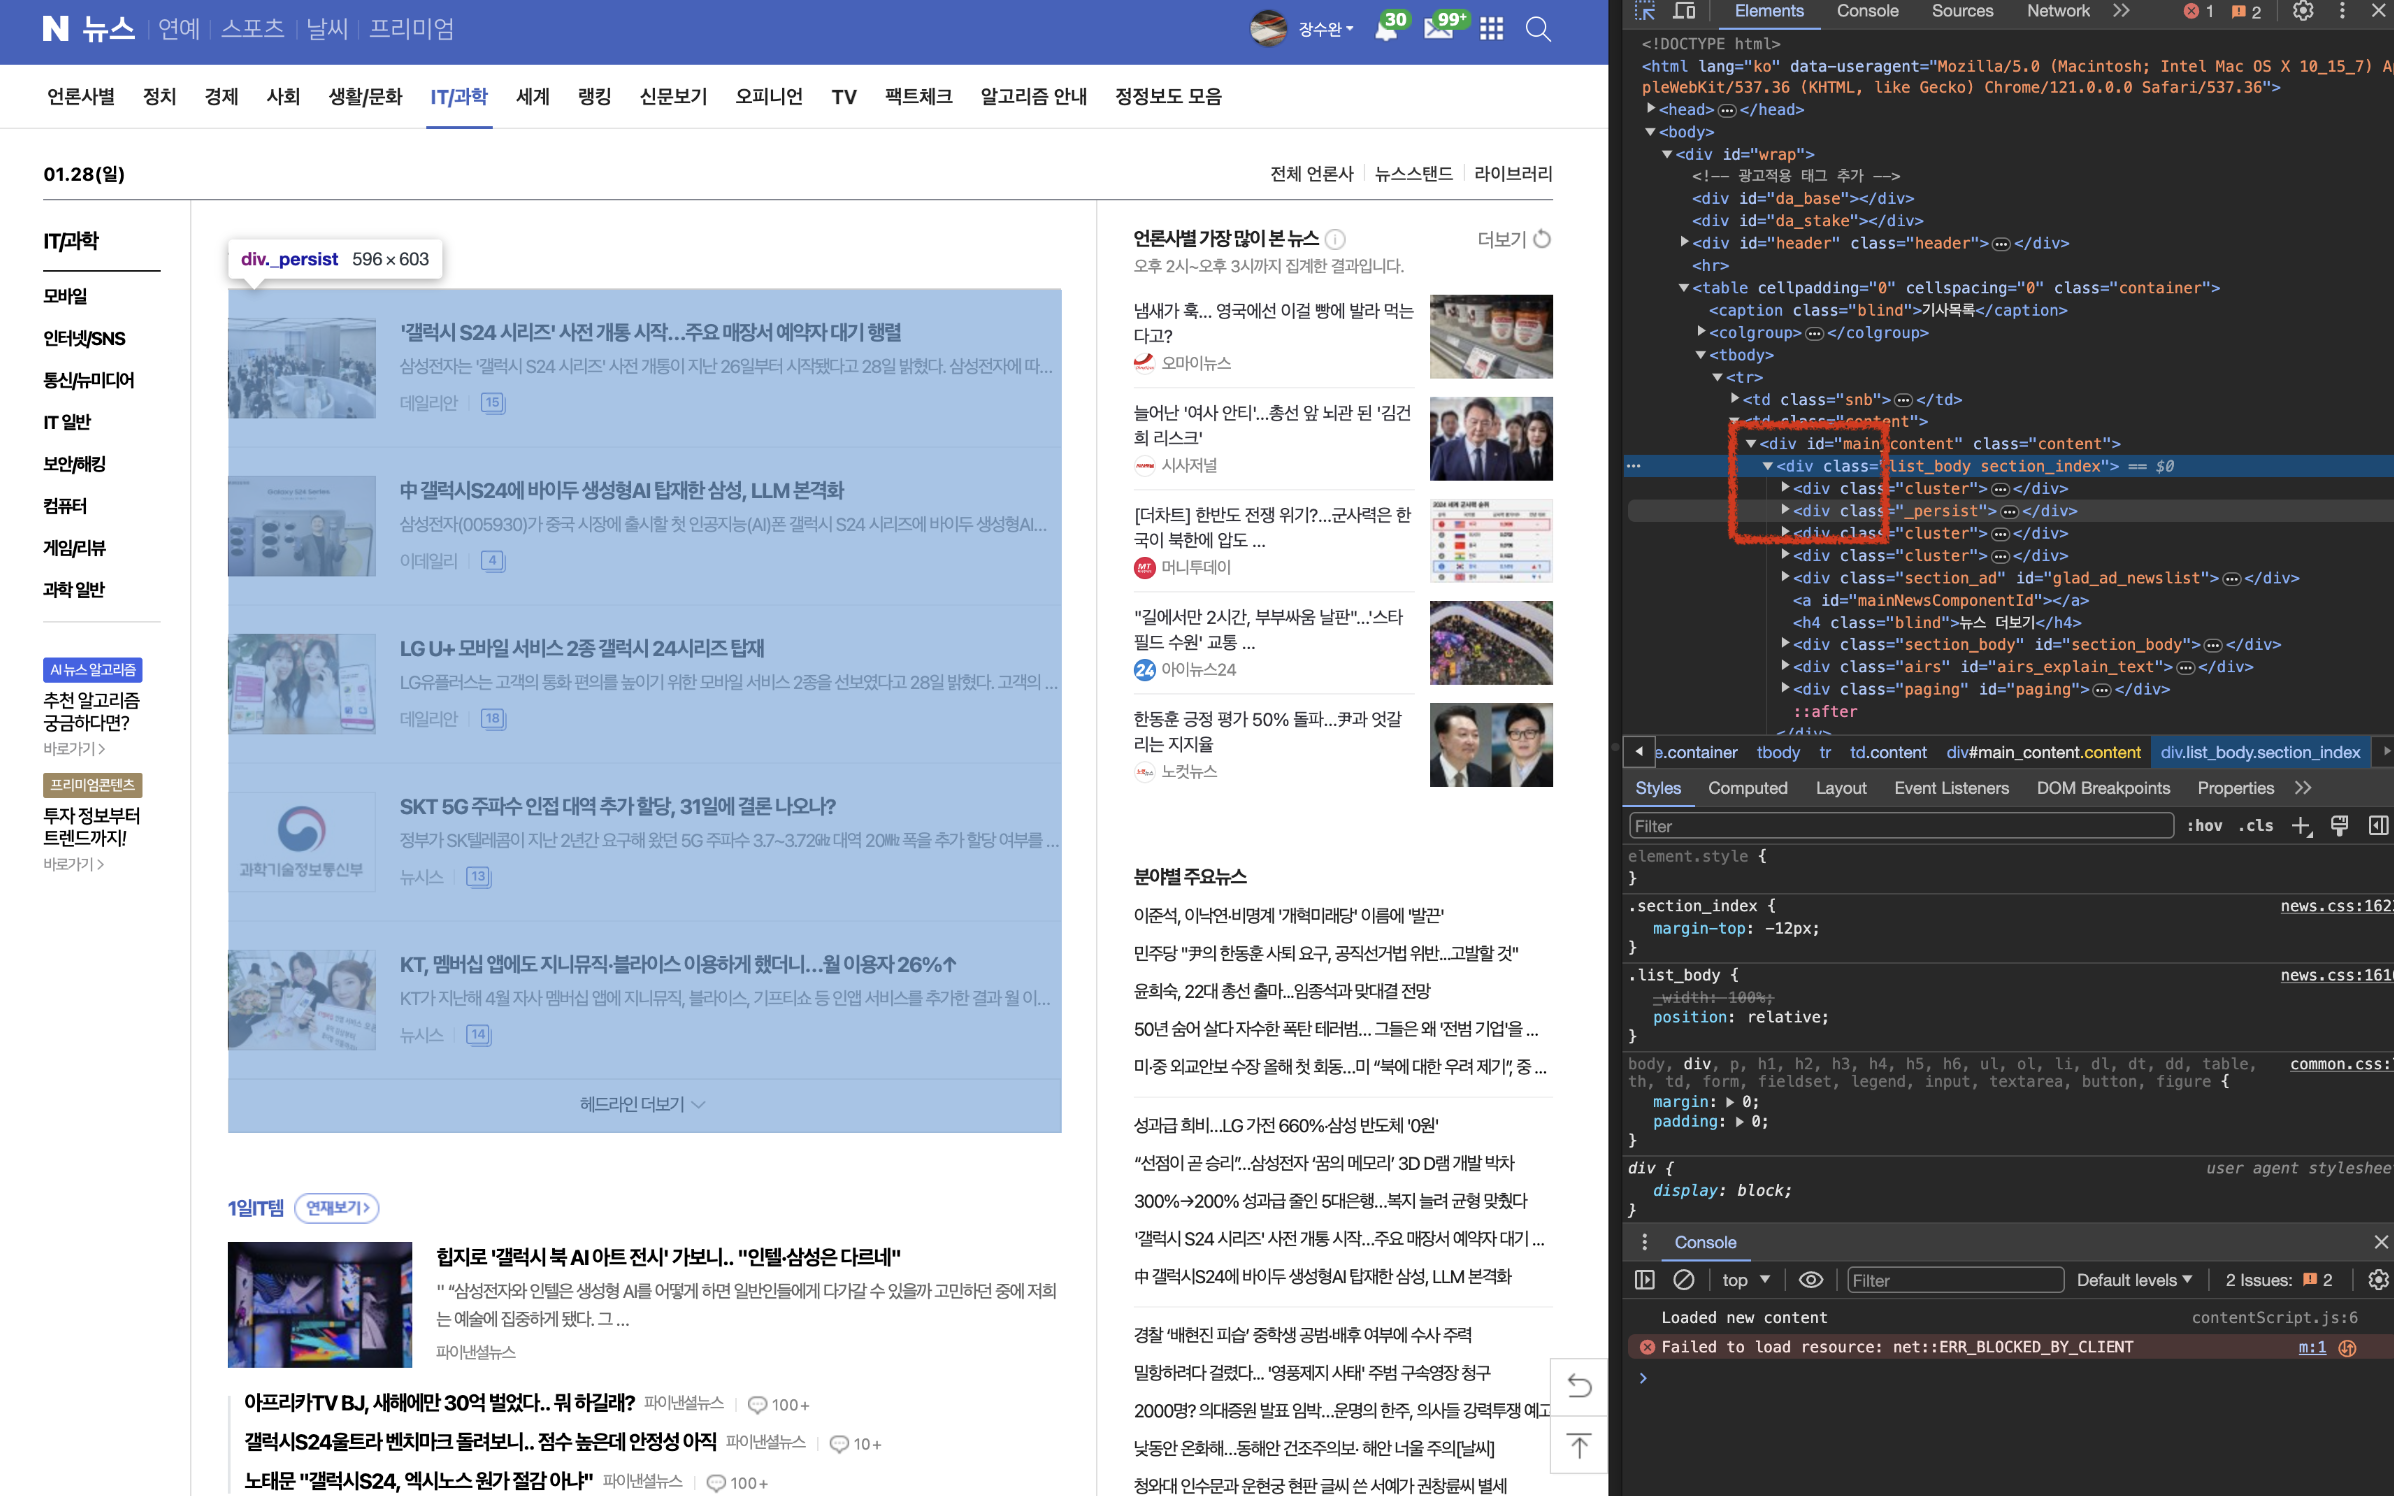

In [ ]:
from langchain.document_loaders import AsyncChromiumLoader

urls = ["https://news.naver.com/main/main.naver?mode=LSD&mid=shm&sid1=105"]
loader = AsyncChromiumLoader(urls)
html = loader.load()


/usr/lib/python3.10/json/decoder.py:353: RuntimeWarning: coroutine 'AsyncChromiumLoader.ascrape_playwright' was never awaited
  obj, end = self.scan_once(s, idx)


**BeautifulSoupTransformer로 Html을 파싱 하기**

이제 html을 llm이 분석하기 쉽도록 변형이 필요하다.

In [ ]:
from langchain_community.document_transformers import BeautifulSoupTransformer

bs_transformer = BeautifulSoupTransformer()
docs_transformed = bs_transformer.transform_documents(html, tags_to_extract=["div"])

위 코드에서 중요한 점은 ```tags_to_extract``` 이다. tag를 포함한 html 기준으로 transform을 수행하는데 기준이 될 tag를 선택해줘야 한다.
분석하고자 하는 정보가 포함된 tag를 지정해주지 않으면 html 내에서 원하는 정보를 가져오지 못한다.

이를 확인하기 위한 방법은 html을 봐도 좋지만, 크롬에서 "검사"를 통해 원하는 정보들이 어떠한 Tag로 구성되어 있는지 확인하면 된다.





**LLM에게 전달해서 쉽게 정보 추출하기**

일반적인 크롤링에선 BeautifulSoup를 통해 Html을 파싱 했다면 이제 뉴스 제목을 추출하기 위해 제목에 해당되는 Selector 혹은 XPath를 통해 제목을 가져와야 한다.

하지만 이 방법의 문제점은, 완벽히 해당 웹페이지의 소스코드에 의존한다는 것이다. 웹페이지의 구성이 변경된다면 기존에 작성했던 크롤링을 위한 로직은 동작하지 않는다.

LLM은 적절한 정보를 전달하면 정보로부터 제목을 추출할 수 있다.
여기서 적절한 정보는 앞서 BeautifulSoupTransformer을 통해 변환한 docs 정보이다.

LLM에게 전달하기 앞서 허용토큰 길이를 고려해서 입력해줘야 한다. 문서를 쪼개야 하는데 이때 ```RecursiveCharacterTextSplitter``` 라는 컴포넌트를 사용할 수 있다.


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
chunk_size=1000, chunk_overlap=0
)
splits = splitter.split_documents(docs_transformed)


이제 정보를 추출하기 위해선 원하는 "정보"가 있어야 한다. langchain은 content로부터 원하는 schema의 정보를 추출할 수 있는 ```create_extraction_chain``` 메소드를 지원한다.



In [ ]:
import os
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

from langchain_google_genai import ChatGoogleGenerativeAI

# ChatGoogleGenerativeAI 언어 모델을 "gemini-pro" 모델로 초기화합니다.
llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0)

이하 코드에서는 정상적으로 작동하지 않는다.
create_extraction_chain 을 사용하기 위해서는 llm 이 Open AI 만 지원하는 것으로 보인다.

llm 을 추상화하여 사용할 수 있도록 langchain 이 나온것 아닌가 싶은데, 현재로서는 방법을 딱히 모르겠다.

아래는 관련 이슈들이다

https://github.com/langchain-ai/langchain/issues/10201
https://github.com/langchain-ai/langchain/issues/13847#issuecomment-1828514681


In [ ]:
from langchain.chains import create_extraction_chain

schema = {
    "properties": {
        "뉴스 제목": {"type": "string"},
        "언론사": {"type": "string"},
    },
    "required": ["뉴스 제목", "언론사"],
}

def extract(content: str, schema: dict):
    return create_extraction_chain(schema=schema, llm=llm).run(content)


content로부터 "뉴스 제목", "언론사"를 추출하는 chain이다.

임의의 content를 넣어서 사용해 보자.


In [ ]:
content = "뉴스제목은 '갤럭시 S24 시리즈' 사전 개통 시작…주요 매장서 예약자 대기 행렬이다. 그리고 언론사는 데일리안이다."

extract(content=content, schema=schema)
# [{'뉴스 제목': '갤럭시 S24 시리즈 사전 개통 시작…주요 매장서 예약자 대기 행렬', '언론사': '데일리안'}]


TypeError: ChatSession.send_message() got an unexpected keyword argument 'function_call'

너무 쉽게 정보를 전달했지만 원하는 정보를 잘 추출하는 걸 확인할 수 있다.

이제 splits 된 content들을 모두 해당 chain에 넣어서 뉴스 제목과 언론사 정보를 추출하는 코드를 완성해 보자.

In [ ]:
from tqdm import tqdm

extracted_contents = []
for split in tqdm(splits):
    extracted_content = extract(content=split.page_content, schema=schema)
    extracted_contents.extend(extracted_content)

# [{'뉴스 제목': "갤S24 사전개통 인파 '북적'…마감일 8일 연장", '언론사': '지디넷코리아'},
# {'뉴스 제목': '삼성, 갤럭시S24 중국 버전에 바이두 AI 챗봇 탑재', '언론사': '뉴시스'},
# {'뉴스 제목': '결국 탈선한 꿈의 ‘애플카’…10년 만에 시동 꺼진 완전자율주행', '언론사': '한국일보'},
# {'뉴스 제목': '인공지능(AI), 무차별 일자리 공습 ‘ON’… “안전지대가 없다”', '언론사': '한국일보'},
# ...
# {'뉴스 제목': '오픈AI, 연초부터 법정 공방 ‘가시밭길’…출판계-언론계 ‘정조준’', '언론사': '한국일보'},
# {'뉴스 제목': '‘챗GPT’ 개발사 오픈AI, 올해 매출 6조5,000억 전망…폭풍성장', '언론사': '한국일보'},
# {'뉴스 제목': '삼성‧SK‧인텔이 지갑 열었다, 반도체 유리기판 뭐길래? <2편>', '언론사': '서울경제'},
# {'뉴스 제목': '삼성‧SK‧인텔이 지갑 열었다, 반도체 유리기판 뭐길래? <1편>', '언론사': '서울경제'},
# {'뉴스 제목': "2년 만에 '반도체 왕좌'서 밀려난 삼성전자…1위 오른 기업은?", '언론사': '서울경제'},
# {'뉴스 제목': "'이천 쌀집' SK하이닉스 1년 농사 계획 엿보기", '언론사': '서울경제'},
# {'뉴스 제목': '서비스 안내', '언론사': '422'}]

대부분의 결과가 나쁘지 않게 나오긴 했는데, 후처리가 조금 더 필요할 거 같다.